In [1]:
from scipy.io import loadmat
import os
import torch
from torch import nn
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import time
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import statistics
from statistics import NormalDist
import random
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

device = torch.device("cuda")

In [3]:
imgpath = '/app/jupyter_space/sample-project/text_image_classifier/data/flowers102/images/'
txtpath = '/app/jupyter_space/sample-project/text_image_classifier/data/flowers102/text/'

modelpath = '/app/jupyter_space/sample-project/text_image_classifier/models'

### Prepare dataset

In [4]:
# resize images to ensure same shape in tensors, done
# os.chdir(imgpath)
# for _, _, filenames in os.walk(imgpath):
#     for file in filenames:
#         image = Image.open(file)
#         image = image.resize((128, 128))
#         image.save(file)

In [5]:
imgsam = []
os.chdir(imgpath)
convert_tensor = transforms.ToTensor()
filenames = []
print(imgpath)
for _, _, filesname in os.walk(imgpath):
    for file in sorted(filesname):
        filenames.append(file)
        img = Image.open(file)
        imgsam.extend([convert_tensor(img)])

/app/jupyter_space/sample-project/text_image_classifier/data/flowers102/images/


In [6]:
len(imgsam)

8189

In [7]:
filenames[:10]

['image_00001.jpg',
 'image_00002.jpg',
 'image_00003.jpg',
 'image_00004.jpg',
 'image_00005.jpg',
 'image_00006.jpg',
 'image_00007.jpg',
 'image_00008.jpg',
 'image_00009.jpg',
 'image_00010.jpg']

In [8]:
txtdes = []
os.chdir(txtpath)
filenames = []
for _, _, filesname in os.walk(txtpath):
    for file in sorted(filesname):
        filenames.append(file)
        with open(file, 'r') as f:
            txtdes.extend([f.read().replace('\n',' ')])

In [9]:
len(txtdes)

8189

In [10]:
filenames[:10]

['image_00001.txt',
 'image_00002.txt',
 'image_00003.txt',
 'image_00004.txt',
 'image_00005.txt',
 'image_00006.txt',
 'image_00007.txt',
 'image_00008.txt',
 'image_00009.txt',
 'image_00010.txt']

In [11]:
train_txt, temp_txt, train_img, temp_img = train_test_split(txtdes, imgsam, test_size=0.5, random_state=0)
val_txt, test_txt, val_img, test_img = train_test_split(temp_txt, temp_img, train_size=0.05, test_size=0.05, random_state=0)

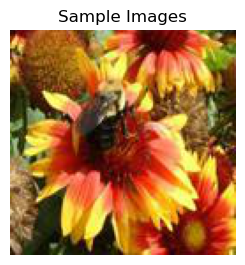

'this flower has petals that are red with yellow tips the petals of this flower are orange and red with a long stigma this flower is orange and yellow in color, with petals that are yellow on the tips. this is a yellow flower with orange on the petals and red stamen. the flower has many petals that are red with yellow tips and red stamen. bright yellow and orange make up the colors of the petals. this flower has petals that are orange and has yellow tips this flower is pink and yellow in color, and has petals that are multi colored. red stigma flowing into a reddish orange petals that are tipped in yellow the petals of this flower are orange with yellow tips and the pedicel is green '

In [12]:
sample_id = 1
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Sample Images")
plt.imshow(np.transpose(train_img[sample_id],(1, 2, 0)))
plt.show()
display(train_txt[sample_id])

In [13]:
print(len(train_txt))

4094


#### tokenization

In [14]:
max_seq_len = 150

bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# tokenize and encode sequences
tokens_train = tokenizer.batch_encode_plus(train_txt, max_length = max_seq_len, pad_to_max_length=True, truncation=True, return_token_type_ids=False)
tokens_val = tokenizer.batch_encode_plus(val_txt, max_length = max_seq_len, pad_to_max_length=True, truncation=True, return_token_type_ids=False)
tokens_test = tokenizer.batch_encode_plus(test_txt, max_length = max_seq_len, pad_to_max_length=True, truncation=True, return_token_type_ids=False)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

# Stack image Tensor
train_img = torch.stack(train_img)
val_img = torch.stack(val_img)
test_img = torch.stack(test_img)

train_data = TensorDataset(train_seq, train_mask, train_img)
val_data = TensorDataset(val_seq, val_mask, val_img)
test_data = TensorDataset(test_seq, test_mask, test_img)

batchsize = 20

train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batchsize, drop_last=True)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batchsize)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batchsize)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/lawrenceliu/anaconda3/envs/deeplearning/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_len

### Models

In [15]:
class BERT_Arch(nn.Module):
    def __init__(self, bert, nooffeatures):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, nooffeatures)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [16]:
noofoutfeature = 1000

imgmodel = models.googlenet(weights='DEFAULT')   
infeature_ResNet = imgmodel.fc.in_features  
imgmodel.fc = nn.Linear(infeature_ResNet, noofoutfeature)

imgmodel = imgmodel.cuda()
txtmodel = BERT_Arch(bert, noofoutfeature)
txtmodel = txtmodel.cuda()

learning_rate = 1e-5
optimizer = optim.AdamW([{'params': txtmodel.parameters()},
                {'params': imgmodel.parameters()}], lr=learning_rate)

Epochs = 200
val_loss = []

for param in bert.parameters():
    param.requires_grad = True
    
pdist = nn.PairwiseDistance(p=2)

In [17]:
from classifier_functions import loss_func, train, evaluate, test

Epoch 1
Saving Model
Training Loss: 0.98712
Validation Loss: 0.90319
Classify L2 Distance: 12.21129
Epoch 2
Saving Model
Training Loss: 0.68853
Validation Loss: 0.50604
Classify L2 Distance: 11.33956
Epoch 3
Saving Model
Training Loss: 0.47149
Validation Loss: 0.40398
Classify L2 Distance: 17.41167
Epoch 4
Saving Model
Training Loss: 0.38339
Validation Loss: 0.38626
Classify L2 Distance: 13.19253
Epoch 5
Saving Model
Training Loss: 0.33962
Validation Loss: 0.32922
Classify L2 Distance: 7.43929
Epoch 6
Saving Model
Training Loss: 0.33130
Validation Loss: 0.31979
Classify L2 Distance: 7.89015
Epoch 7
Saving Model
Training Loss: 0.29948
Validation Loss: 0.30035
Classify L2 Distance: 7.94268
Epoch 8
Saving Model
Training Loss: 0.28637
Validation Loss: 0.29181
Classify L2 Distance: 6.23280
Epoch 9
Saving Model
Training Loss: 0.25596
Validation Loss: 0.27736
Classify L2 Distance: 11.42217
Epoch 10
Saving Model
Training Loss: 0.25202
Validation Loss: 0.27579
Classify L2 Distance: 8.16231
Epoc

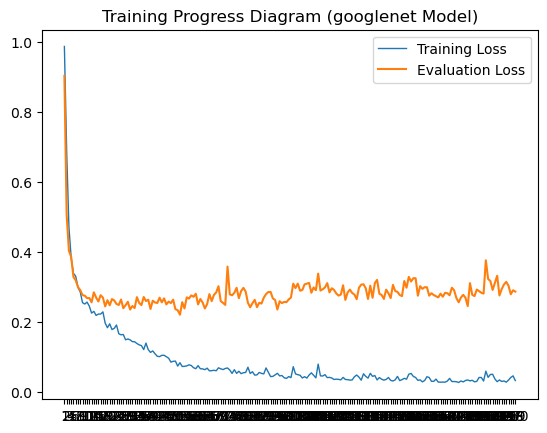

In [18]:
proposed_model = "googlenet"

best_val_loss = float('inf')
os.chdir(modelpath)

train_losses = []
eval_losses = []
elapsedtime = time.time()
for epoch in range(Epochs):
    print('Epoch %d' % (epoch + 1))
    train_loss, train_samepairdist = train(imgmodel, txtmodel, train_dataloader, optimizer)
    eval_loss, eval_samepairdist = evaluate(imgmodel, txtmodel, val_dataloader)

    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        print('Saving Model')
        torch.save(txtmodel, 'Text_Model_' + proposed_model + '.pt')
        torch.save(imgmodel, 'Image_Model_' + proposed_model + '.pt')
        mean = statistics.mean(train_samepairdist)
        sd = statistics.stdev(eval_samepairdist)
        dist = NormalDist()
        inclusive_dist = mean

    print('Training Loss: %.5f' % train_loss)
    print('Validation Loss: %.5f' % eval_loss)
    print('Classify L2 Distance: %.5f' % inclusive_dist)

    train_losses.extend([train_loss])
    eval_losses.extend([eval_loss])


running_result = 'result' + proposed_model + '.dat'

elapsedtime = time.time()-elapsedtime
print('Running Time: %d min %d sec' % (elapsedtime//60, elapsedtime % 60))

_, check, _ = test(imgmodel, txtmodel, test_dataloader, topk=int(len(test_seq) * 0.03))
check = check.tolist()

counter = 0
for checking in check:
    if checking:
        counter += 1
        
Falsecounter = len(check)-counter
Accuracy = counter / len(check)
print('No of Truth case: \t %d' % counter)
print('No of False case: \t %d' % Falsecounter)
print('Accuracy: \t \t %.4f' % (Accuracy*100))

result = [counter+Falsecounter, counter, Accuracy*100, elapsedtime]

Classifier = [mean, sd, inclusive_dist]
dictionary = {'Name': proposed_model, 'Tloss': train_losses, 'Eloss': eval_losses, 'Critieria': Classifier, 'Result': result}

f = open(running_result, 'wb')
pickle.dump(dictionary, f)
f.close()

x = [num for num in range(1, len(train_losses)+1)]

lines = plt.plot(x, train_losses, x, eval_losses)
plt.setp(lines[0], linewidth=1)
plt.xticks(x)
plt.legend(('Training Loss', 'Evaluation Loss'), loc='upper right')
plt.title('Training Progress Diagram (' + proposed_model + ' Model)')
plt.savefig(proposed_model + '.png')
plt.show()
plt.close()